Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

L2 regularization(beta=0.00010) Test accuracy: 85.7%
L2 regularization(beta=0.00013) Test accuracy: 86.2%
L2 regularization(beta=0.00016) Test accuracy: 85.9%
L2 regularization(beta=0.00021) Test accuracy: 86.6%
L2 regularization(beta=0.00026) Test accuracy: 86.5%
L2 regularization(beta=0.00034) Test accuracy: 86.6%
L2 regularization(beta=0.00043) Test accuracy: 87.6%
L2 regularization(beta=0.00055) Test accuracy: 87.3%
L2 regularization(beta=0.00070) Test accuracy: 87.9%
L2 regularization(beta=0.00089) Test accuracy: 88.2%
L2 regularization(beta=0.00113) Test accuracy: 88.2%
L2 regularization(beta=0.00144) Test accuracy: 88.3%
L2 regularization(beta=0.00183) Test accuracy: 88.3%
L2 regularization(beta=0.00234) Test accuracy: 88.3%
L2 regularization(beta=0.00298) Test accuracy: 88.1%
L2 regularization(beta=0.00379) Test accuracy: 88.0%
L2 regularization(beta=0.00483) Test accuracy: 87.9%
L2 regularization(beta=0.00616) Test accuracy: 87.8%
L2 regularization(beta=0.00785) Test accuracy:

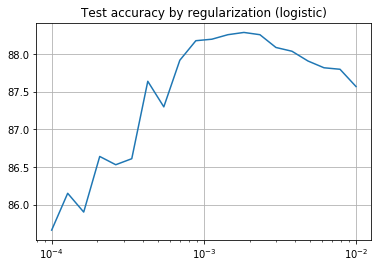

In [6]:
import matplotlib.pyplot as plt

beta_val = np.logspace(-4, -2, 20)
accuracy_val = []
 
# logistic model
batch_size = 128
 
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
 
    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
 
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + \
        beta_regul * tf.nn.l2_loss(weights)
 
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
 
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
 
num_steps = 3001
 
for beta in beta_val:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta_regul: beta}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            # if (step % 500 == 0):
            #     print("Minibatch loss at step %d: %f" % (step, l))
            #     print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            #     print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        print("L2 regularization(beta=%.5f) Test accuracy: %.1f%%" % (
            beta, accuracy(test_prediction.eval(), test_labels)))
 
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))
 
print('Best beta=%f, accuracy=%.1f%%' % (beta_val[np.argmax(accuracy_val)], max(accuracy_val)))
plt.semilogx(beta_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

L2 regularization(beta=0.00010) Test accuracy: 88.5%
L2 regularization(beta=0.00013) Test accuracy: 89.3%
L2 regularization(beta=0.00016) Test accuracy: 89.3%
L2 regularization(beta=0.00021) Test accuracy: 88.7%
L2 regularization(beta=0.00026) Test accuracy: 89.2%
L2 regularization(beta=0.00034) Test accuracy: 90.2%
L2 regularization(beta=0.00043) Test accuracy: 90.1%
L2 regularization(beta=0.00055) Test accuracy: 90.4%
L2 regularization(beta=0.00070) Test accuracy: 91.9%
L2 regularization(beta=0.00089) Test accuracy: 92.2%
L2 regularization(beta=0.00113) Test accuracy: 92.7%
L2 regularization(beta=0.00144) Test accuracy: 93.0%
L2 regularization(beta=0.00183) Test accuracy: 92.5%
L2 regularization(beta=0.00234) Test accuracy: 92.1%
L2 regularization(beta=0.00298) Test accuracy: 91.3%
L2 regularization(beta=0.00379) Test accuracy: 91.0%
L2 regularization(beta=0.00483) Test accuracy: 90.6%
L2 regularization(beta=0.00616) Test accuracy: 90.2%
L2 regularization(beta=0.00785) Test accuracy:

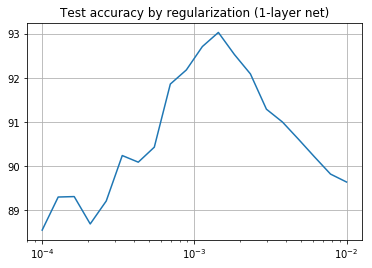

In [9]:
# NN model
batch_size = 128
hidden_size = 1024
 
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta = tf.placeholder(tf.float32)
 
    # Variables.
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_size]))
    b1 = tf.Variable(tf.zeros([hidden_size]))
 
    W2 = tf.Variable(tf.truncated_normal([hidden_size, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))
 
    # Training computation.
    y1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    logits = tf.matmul(y1, W2) + b2
 
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
 
    loss = loss + tf_beta * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(b2))
 
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
 
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
 
    y1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    valid_logits = tf.matmul(y1_valid, W2) + b2
    valid_prediction = tf.nn.softmax(valid_logits)
 
    y1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    test_logits = tf.matmul(y1_test, W2) + b2
    test_prediction = tf.nn.softmax(test_logits)
 
# Let's run it:
num_steps = 3001
 
del accuracy_val[:]
for beta in np.logspace(-4, -2, 20):
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        # print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta: beta}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            # if (step % 500 == 0):
            #     print("Minibatch loss at step %d: %f" % (step, l))
            #     print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            #     print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        print("L2 regularization(beta=%.5f) Test accuracy: %.1f%%" % (
            beta, accuracy(test_prediction.eval(), test_labels)))
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))
 
print('Best beta=%f, accuracy=%.1f%%' % (beta_val[np.argmax(accuracy_val)], max(accuracy_val)))
plt.semilogx(beta_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (1-layer net)')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [10]:
few_batch_size = batch_size * 5
small_train_dataset = train_dataset[:few_batch_size, :]
small_train_labels = train_labels[:few_batch_size, :]
 
print('Training set', small_train_dataset.shape, small_train_labels.shape)
 
num_steps = 3001
 
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (small_train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = small_train_dataset[offset:(offset + batch_size), :]
        batch_labels = small_train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta: 0.001438}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Overfitting with small dataset Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Training set (640, 784) (640, 10)
Initialized
Minibatch loss at step 0: 847.193115
Minibatch accuracy: 3.9%
Validation accuracy: 39.7%
Minibatch loss at step 500: 220.501953
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 1000: 107.409592
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 1500: 52.321232
Minibatch accuracy: 100.0%
Validation accuracy: 74.8%
Minibatch loss at step 2000: 25.488359
Minibatch accuracy: 100.0%
Validation accuracy: 75.2%
Minibatch loss at step 2500: 12.421490
Minibatch accuracy: 100.0%
Validation accuracy: 75.9%
Minibatch loss at step 3000: 6.064439
Minibatch accuracy: 100.0%
Validation accuracy: 77.0%
Overfitting with small dataset Test accuracy: 84.6%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [11]:
batch_size = 128
hidden_size = 1024
 
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta = tf.placeholder(tf.float32)
 
    # Variables.
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_size]))
    b1 = tf.Variable(tf.zeros([hidden_size]))
 
    W2 = tf.Variable(tf.truncated_normal([hidden_size, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))
 
    # Training computation.
    y1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    y1 = tf.nn.dropout(y1, 0.5)  # Dropout
    logits = tf.matmul(y1, W2) + b2
 
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
 
    loss = loss + tf_beta * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(b2))
 
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
 
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
 
    y1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    valid_logits = tf.matmul(y1_valid, W2) + b2
    valid_prediction = tf.nn.softmax(valid_logits)
 
    y1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    test_logits = tf.matmul(y1_test, W2) + b2
    test_prediction = tf.nn.softmax(test_logits)
 
# Let's run it:
num_steps = 3001
 
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta: 0.001438}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Dropout Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 987.321655
Minibatch accuracy: 7.0%
Validation accuracy: 42.0%
Minibatch loss at step 500: 231.272629
Minibatch accuracy: 75.8%
Validation accuracy: 79.8%
Minibatch loss at step 1000: 113.634628
Minibatch accuracy: 75.8%
Validation accuracy: 79.6%
Minibatch loss at step 1500: 52.898285
Minibatch accuracy: 73.4%
Validation accuracy: 81.3%
Minibatch loss at step 2000: 25.718674
Minibatch accuracy: 82.8%
Validation accuracy: 84.5%
Minibatch loss at step 2500: 12.820609
Minibatch accuracy: 78.9%
Validation accuracy: 85.2%
Minibatch loss at step 3000: 6.620392
Minibatch accuracy: 78.9%
Validation accuracy: 85.6%
Dropout Test accuracy: 92.1%


In [12]:
few_batch_size = batch_size * 5
small_train_dataset = train_dataset[:few_batch_size, :]
small_train_labels = train_labels[:few_batch_size, :]
 
print('Training set', small_train_dataset.shape, small_train_labels.shape)
 
num_steps = 3001
 
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (small_train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = small_train_dataset[offset:(offset + batch_size), :]
        batch_labels = small_train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta: 0.001438}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Dropout with small dataset Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Training set (640, 784) (640, 10)
Initialized
Minibatch loss at step 0: 962.428528
Minibatch accuracy: 6.2%
Validation accuracy: 26.1%
Minibatch loss at step 500: 221.107864
Minibatch accuracy: 100.0%
Validation accuracy: 78.0%
Minibatch loss at step 1000: 107.795952
Minibatch accuracy: 99.2%
Validation accuracy: 78.0%
Minibatch loss at step 1500: 52.512691
Minibatch accuracy: 100.0%
Validation accuracy: 78.4%
Minibatch loss at step 2000: 25.587166
Minibatch accuracy: 100.0%
Validation accuracy: 78.4%
Minibatch loss at step 2500: 12.466058
Minibatch accuracy: 100.0%
Validation accuracy: 78.6%
Minibatch loss at step 3000: 6.078213
Minibatch accuracy: 100.0%
Validation accuracy: 78.7%
Dropout with small dataset Test accuracy: 86.1%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [13]:
batch_size = 128
fc1_size = 4096
fc2_size = 2048
fc3_size = 128
 
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta = tf.placeholder(tf.float32)
    global_step = tf.Variable(0)  # count the number of steps taken.
 
    # Variables.
    # stddev is very important!!!
    W1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, fc1_size], stddev=np.sqrt(2.0 / (image_size * image_size))))
    b1 = tf.Variable(tf.zeros([fc1_size]))
 
    W2 = tf.Variable(tf.truncated_normal([fc1_size, fc2_size], stddev=np.sqrt(2.0 / fc1_size)))
    b2 = tf.Variable(tf.zeros([fc2_size]))
 
    W3 = tf.Variable(tf.truncated_normal([fc2_size, fc3_size], stddev=np.sqrt(2.0 / fc2_size)))
    b3 = tf.Variable(tf.zeros([fc3_size]))
 
    W4 = tf.Variable(tf.truncated_normal([fc3_size, num_labels], stddev=np.sqrt(2.0 / fc3_size)))
    b4 = tf.Variable(tf.zeros([num_labels]))
 
    # Training computation.
    y1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    # y1 = tf.nn.dropout(y1, 0.5)
 
    y2 = tf.nn.relu(tf.matmul(y1, W2) + b2)
    # y2 = tf.nn.dropout(y2, 0.5)
 
    y3 = tf.nn.relu(tf.matmul(y2, W3) + b3)
    # y3 = tf.nn.dropout(y3, 0.5)
 
    logits = tf.matmul(y3, W4) + b4
 
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
 
    loss = loss + tf_beta * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(b2) +
                             tf.nn.l2_loss(W3) + tf.nn.l2_loss(b3) + tf.nn.l2_loss(W4) + tf.nn.l2_loss(b4))
 
    # Optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.7, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
 
    y1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    y2_valid = tf.nn.relu(tf.matmul(y1_valid, W2) + b2)
    y3_valid = tf.nn.relu(tf.matmul(y2_valid, W3) + b3)
    valid_logits = tf.matmul(y3_valid, W4) + b4
    valid_prediction = tf.nn.softmax(valid_logits)
 
    y1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    y2_test = tf.nn.relu(tf.matmul(y1_test, W2) + b2)
    y3_test = tf.nn.relu(tf.matmul(y2_test, W3) + b3)
    test_logits = tf.matmul(y3_test, W4) + b4
    test_prediction = tf.nn.softmax(test_logits)
 
# Let's run it:
num_steps = 12001
 
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta: 0.001438}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Final Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 9.403552
Minibatch accuracy: 10.2%
Validation accuracy: 30.5%
Minibatch loss at step 500: 4.065445
Minibatch accuracy: 87.5%
Validation accuracy: 85.9%
Minibatch loss at step 1000: 2.328501
Minibatch accuracy: 86.7%
Validation accuracy: 87.4%
Minibatch loss at step 1500: 1.692960
Minibatch accuracy: 85.2%
Validation accuracy: 87.8%
Minibatch loss at step 2000: 1.079401
Minibatch accuracy: 90.6%
Validation accuracy: 88.0%
Minibatch loss at step 2500: 0.961870
Minibatch accuracy: 88.3%
Validation accuracy: 88.6%
Minibatch loss at step 3000: 0.831364
Minibatch accuracy: 88.3%
Validation accuracy: 88.0%
Minibatch loss at step 3500: 0.656939
Minibatch accuracy: 90.6%
Validation accuracy: 89.5%
Minibatch loss at step 4000: 0.748441
Minibatch accuracy: 85.9%
Validation accuracy: 89.4%
Minibatch loss at step 4500: 0.593434
Minibatch accuracy: 89.8%
Validation accuracy: 89.5%
Minibatch loss at step 5000: 0.514674
Minibatch accuracy: 93.0%
Validation accurac